In [1]:
import sys
import os

# Obtém o diretório raiz do pacote
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Adiciona o diretório raiz ao sys.path
sys.path.append(root_dir)

import lightning.pytorch as pl
from datamodule.chirps_cmip6 import ChirpsDataModule, ChirpsCmip6DataModule, Chirps, ChirpsCmip6
from model.swin2sr import Swin2SRLight
from model.swin2sr import Swin2SRLight
from model.vit import VisionTransfomerModule
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchvision import transforms

/Users/dilermando/Library/Caches/pypoetry/virtualenvs/downscaling-emQo10yy-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
model_bias = VisionTransfomerModule(img_size=(32,32), in_channels=1, out_channels=1, history=1)
model_bias = model_bias.load_from_checkpoint("/Users/dilermando/dev/downscaling/model/weights/vit-bias/version_1/checkpoints/epoch=99-step=21600.ckpt")
data_bias = ChirpsCmip6(data_dir="../datamodule/dataset/high-low",
              transformations=False,
              type='eval')

In [6]:
model_downscaling = Swin2SRLight(upscale=5, img_size=(32, 32), in_chans=1,
                window_size=8, img_range=1., depths=[6, 6, 6, 6],
                embed_dim=60, num_heads=[6, 6, 6, 6], mlp_ratio=2, upsampler='pixelshuffledirect')
model_downscaling = model_downscaling.load_from_checkpoint("/Users/dilermando/dev/downscaling/model/weights/swin2sr/version_11/checkpoints/epoch=99-step=21600.ckpt")
data_downscaling = Chirps(data_dir="../datamodule/dataset/high-low",
              transformations=False,
              type='eval')

In [18]:
results = []
model_bias.eval()
model_downscaling.eval()
with torch.no_grad():
    for i in range(len(data_bias)):
        image = data_bias[i][0]
        image = image.unsqueeze(0)
        result_bias = model_bias(image.to('cpu'))
        result_downscaling = model_downscaling(result_bias.to('cpu'))
        result_downscaling = result_downscaling.squeeze(0).squeeze(0).to('cpu').numpy()              
        results.append(result_downscaling)
results = np.array(results)

/Users/dilermando/Library/Caches/pypoetry/virtualenvs/downscaling-emQo10yy-py3.9/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [21]:
chirps = []
for i in range(len(data_downscaling)):
    chirps.append(data_downscaling[i][1].squeeze(0).numpy())

chirps = np.array(chirps)

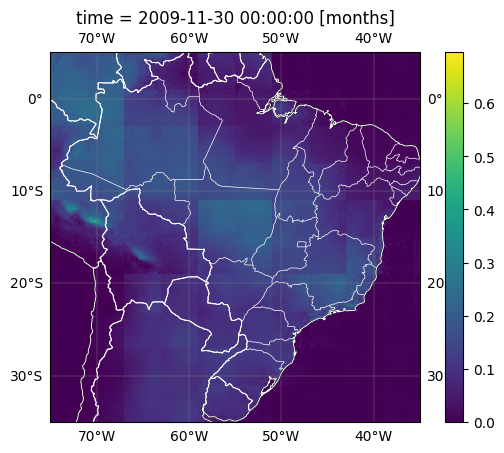

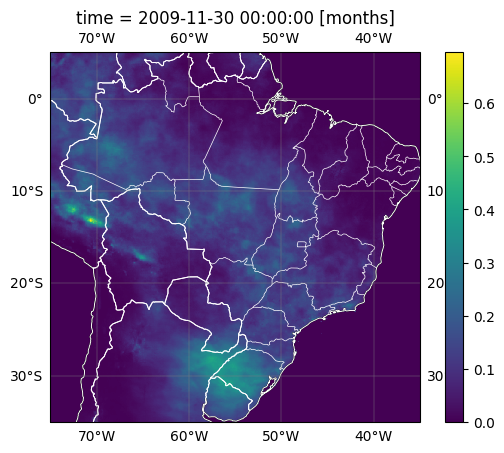

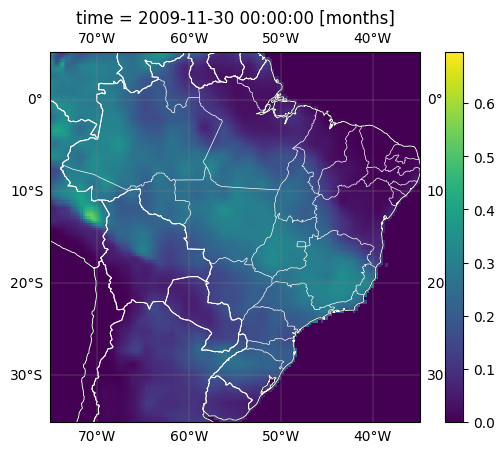

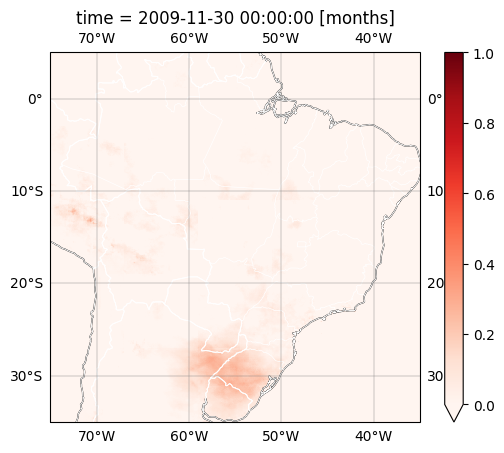

In [65]:
i = 34
reconstruct_chirps = Chirps.reconstruct_image(chirps)
reconstruct_chirps_xr = Chirps.create_xarray(reconstruct_chirps)

reconstruct_model = Chirps.reconstruct_image(np.maximum(results, 0))
reconstruct_model_xr = Chirps.create_xarray(reconstruct_model)

reconstruct_cmip6 = Chirps.reconstruct_image(data_bias.cmip6)
reconstruct_cmip6_xr = Chirps.create_xarray(reconstruct_cmip6)

vmax = np.max([reconstruct_chirps[i].max(), reconstruct_model[i].max(), reconstruct_cmip6[i].max()])

Chirps.plot_map(reconstruct_model_xr, i, vmax=vmax)
Chirps.plot_map(reconstruct_chirps_xr, i, vmax=vmax)
Chirps.plot_map(reconstruct_cmip6_xr, i, vmax=vmax)

error_model = reconstruct_chirps - reconstruct_model
error_model_xr = Chirps.create_xarray(error_model)

Chirps.plot_map(error_model_xr, i, cmap='Reds')


In [71]:
error_sp = error_model_xr.resample(time='96MS').mean(dim='time').sel(latitude=slice(-23.88, -23.4), longitude=slice(-47, -46.25))

In [76]:
error_sp.max()*data_downscaling.chirps_max, error_sp.min()*data_downscaling.chirps_max

(<xarray.DataArray ()>
 array(134.57188268),
 <xarray.DataArray ()>
 array(-142.64122917))

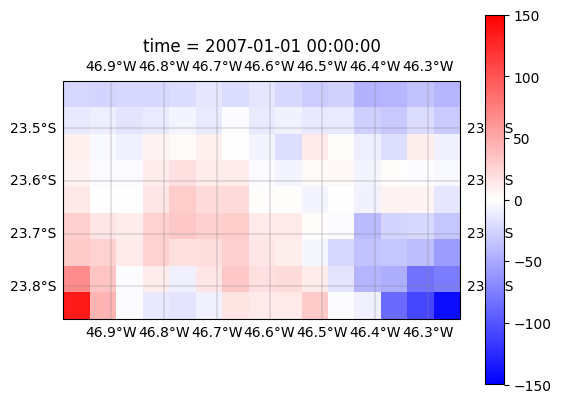

In [77]:
Chirps.plot_map(error_model_xr.resample(time='96MS').mean(dim='time').sel(latitude=slice(-23.88, -23.4), longitude=slice(-47, -46.25))*data_downscaling.chirps_max, 0, vmax=150, vmin=-150, cmap='bwr')

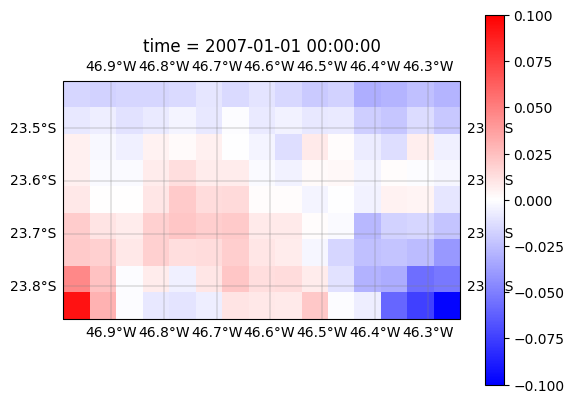

In [74]:
Chirps.plot_map(error_model_xr.resample(time='96MS').mean(dim='time').sel(latitude=slice(-23.88, -23.4), longitude=slice(-47, -46.25)), 0, vmax=0.1, vmin=-0.1, cmap='bwr')

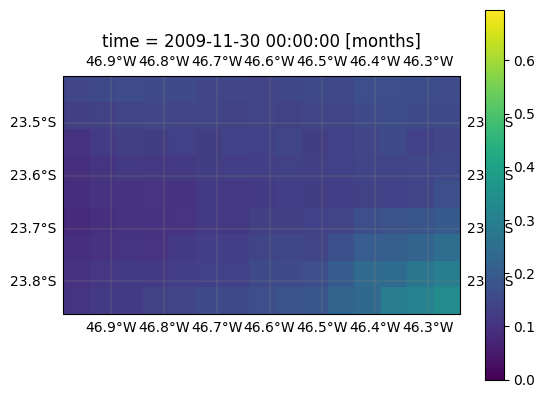

In [53]:
Chirps.plot_map(reconstruct_model_xr.sel(latitude=slice(-23.88, -23.4), longitude=slice(-47, -46.25)), i, vmax=vmax)

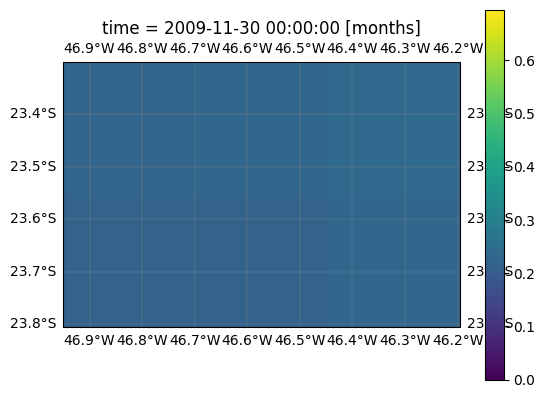

In [55]:
Chirps.plot_map(reconstruct_cmip6_xr.sel(latitude=slice(-23.88, -23.4), longitude=slice(-47, -46.25)), i, vmax=vmax)

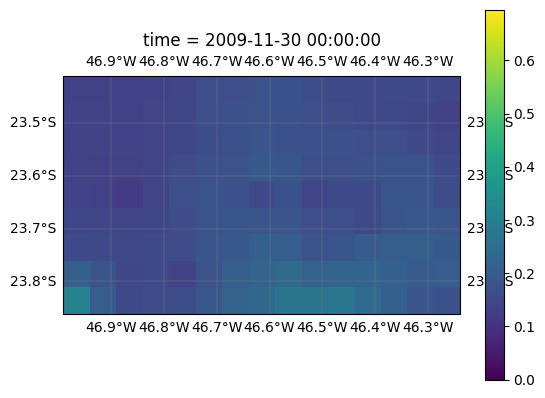

In [54]:
Chirps.plot_map(reconstruct_chirps_xr.sel(latitude=slice(-23.88, -23.4), longitude=slice(-47, -46.25)), i, vmax=vmax)